### Object detection AP ###

In [2]:
import os
import ast
import re
import numpy as np
import pandas as pd
import logging
import glob
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import patches

# PyTorch and HuggingFace Transformers
import torch
from torchvision import ops
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

logger = logging.getLogger(name=__name__)

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.detrdataset import get_gpu_info
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xyxy2xywh, xywh2xyxy, clipxywh
from detection.imageproc import determine_bbox_format
from detection.performance import get_iou

print(f'Project module version: {dt.__version__}')
print(f'PyTorch version:        {torch.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.1.post1.dev31+g14d1a25.d20250315
PyTorch version:        2.6.0a0+ecf3bae40a.nv25.01


### Helper functions ###

In [3]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, bbox_list, label_list=None, alpha=0.7, colors=None, ax=None):
    if colors is None:
        color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
        color_list = [color[c] for c in range(len(color))]
    else:
        assert len(colors)==len(bbox_list), f'Number of colors does not match number bounding boxes.'
        color_list = colors.copy()
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(bbox_list):
        boxcolor = color_list[b]
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+4, y=anchor[1]-4, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

In [4]:
# Check GPU availability
device, device_str = get_gpu_info()

# Directories and files
data_dir = os.path.join(os.environ.get('HOME'), 'data', 'dentex_detection')
image_dir = os.path.join(data_dir, 'quadrants')

# Model directory
model_name = 'rtdetr_250311_06'
model_dir = os.path.join(data_dir, 'models', model_name)

# Log file
log_file_name = 'train_log_250311.log'
log_file = os.path.join(model_dir, log_file_name)

# Output for the images with the predictions
output_dir = os.path.join(model_dir, 'testresults', 'dentexdata')
Path(output_dir).mkdir(parents=True, exist_ok=True)

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.6.0a0+ecf3bae40a.nv25.01
CUDA version:      12.8
CUDNN version:     90700


In [5]:
# Load the log file
with open(log_file, mode='r') as fl:
    log = fl.read()
print(log)

# Load the model from checkpoint
hf_model_name = 'PekingU/rtdetr_v2_r101vd'
processor = RTDetrImageProcessor.from_pretrained(hf_model_name)
checkpoint_name = 'checkpoint-10140'
checkpoint_file = os.path.join(model_dir, checkpoint_name)
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint_file).to(device)

250311-21:25-__main__-INFO-{"output_dir": "/app/data/dentex_detection/model/rtdetr_250311_06", "num_train_epochs": 500, "max_grad_norm": 0.1, "learning_rate": 1e-05, "warmup_steps": 300, "per_device_train_batch_size": 48, "dataloader_num_workers": 8, "metric_for_best_model": "eval_map", "greater_is_better": true, "load_best_model_at_end": true, "eval_strategy": "epoch", "save_strategy": "epoch", "save_total_limit": 5, "remove_unused_columns": false, "eval_do_concat_batches": false}
250311-21:25-__main__-INFO-{"model_version": 6, "model_name": "rtdetr_250311_06", "hf_checkpoint": "PekingU/rtdetr_v2_r101vd", "use_transform": "transform_1"}



### Load the test data ###

In [6]:
dataset_df_file_name = 'train_split_250224.parquet'
dataset_df_file = os.path.join(image_dir, dataset_df_file_name)
df = pd.read_parquet(dataset_df_file)
display(df.head(2))

# Label to ADA postion conversion
ada_list = sorted(list(df['ada'].unique()))
id2label = dict(zip(range(len(ada_list)), ada_list))
label2id = {v: k for k, v in id2label.items()}

# Number of images in data set
n_test_images = len(list(df.loc[df['dset'] == 'test', 'file_name'].unique()))
print(f'Total number of test images: {n_test_images}')

,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",11,8,train
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",12,7,train


Total number of test images: 32


### Predict bounding boxes and class labels from input image ###

In [8]:
def predict_bboxes(model, image, threshold, id2label):
    im_height, im_width = image.shape[:2]
    xlim, ylim = (0, im_width), (0, im_height)
    
    # Run the predictions for this image
    im_input = processor(image, return_tensors='pt').to(device)
    
    # Run the image through the model
    with torch.no_grad():
        model_output = model(**im_input)
    
    results = processor.post_process_object_detection(model_output, 
                                                      target_sizes=torch.tensor([(im_height, im_width)]), 
                                                      threshold=nms_threshold)
    
    results_boxes = results[0].get('boxes').cpu().numpy()
    results_boxes = [clipxywh(xyxy2xywh(list(box)), xlim=xlim, ylim=ylim, decimals=0) for box in results_boxes]
    results_labels = results[0].get('labels').cpu().numpy()
    results_labels = [id2label.get(cl) for cl in results_labels]
    results_scores = results[0].get('scores').cpu().numpy()
    
    output = {'bbox': results_boxes,
              'label': results_labels,
              'score': results_scores,
              'format': 'xywh'}

    # Special for tooth detection: only one bounding box per image
    # We count the number of bounding boxes per class and then 
    # Filter the data frame to keep the bounding box with the highest score
    output_df = pd.DataFrame(output)
    counts = output_df[['label', 'score']].\
                    groupby(by='label').count().\
                    reset_index(drop=False).\
                    rename(columns={'score': 'bboxes_per_label'})
    output_df = output_df.merge(counts, on='label', how='left').\
                    sort_values(by=['label', 'score'], ascending=False).\
                    groupby(by='label').first().\
                    reset_index(drop=False)
    
    return output_df

In [244]:
def ap_scores(preds, scores):
    assert isinstance(preds, list), 'preds must be a list of strings'
    assert isinstance(scores, list), 'scores must be a list of float values'
    # Make sure that predicions only contain 'TP', 'FP' and 'FN'
    pred_values = ['TP', 'FP', 'FN']
    assert sum([p not in pred_values for p in preds]) == 0, 'preds must be in ["TP", "FP", "FN"]'
    # Sort predictions by descending score
    pdf = pd.DataFrame({'preds': preds, 'scores': scores}).\
                sort_values(by='scores', ascending=False).\
                reset_index(drop=True)
    pred_list = pdf['preds'].tolist()
    total_positives = len(pred_list)
    # Count the different values in the list
    # Then, calculate the cumulative sum
    cs_tp = np.cumsum([1 if pred=='TP' else 0 for pred in pred_list])
    cs_fp = np.cumsum([1 if pred=='FP' else 0 for pred in pred_list])
    cs_fn = np.cumsum([1 if pred=='FN' else 0 for pred in pred_list])
    # Calculate the weighted precision and recall values
    cs_precision = cs_tp / (cs_tp + cs_fp)
    cs_recall = cs_tp / total_positives
    # Add (precision, recall) = (1, 0) pair
    cs_precision = np.insert(cs_precision, 0, 1)
    cs_recall = np.insert(cs_recall, 0, 0)
    # Average precision
    ap = np.trapz(y=cs_precision, x=cs_recall)
    # Precision: What fraction of all detections are correct?
    pre = sum(tp) / (sum(tp) + sum(fp))
    # Recall: How many of the total bounding boxes for the class were detected?
    rec = sum(tp) / total_positives
    # F1: Harmonic mean of precision and recall
    f_score = 2 * pre * rec / (pre + rec)
    output = {'cs_precision': cs_precision, 
              'cs_recall': cs_recall, 
              'ap_score': ap, 
              'precision': pre, 
              'recall': rec, 
              'f_score': f_score}
    return output

In [283]:
# Parameters for testing
# Post-processing: Non-Maximum Suppression (NMS)
figsize = (6, 3)
nms_threshold = 0.2
iou_threshold = 0.5
dset = 'test'
dset_col = 'dset'
label_col = 'ada'
file_col = 'file_name'
bbox_col = 'bbox'

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


Processing 7 images for label 1


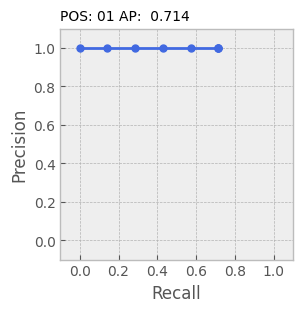

Processing 8 images for label 2


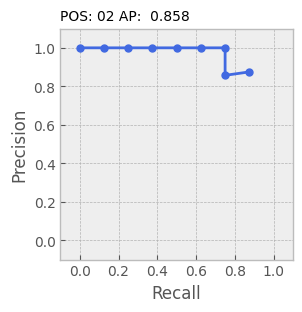

Processing 8 images for label 3


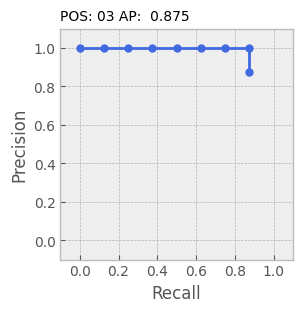

Processing 8 images for label 4


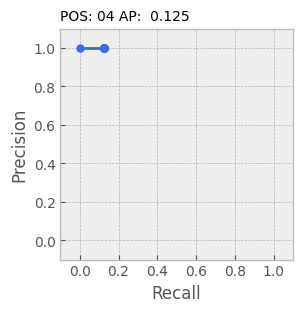

Processing 8 images for label 5


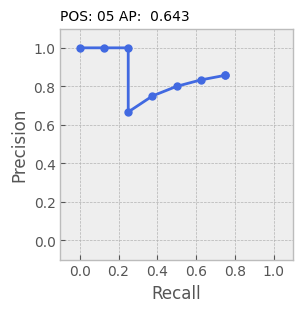

Processing 8 images for label 6


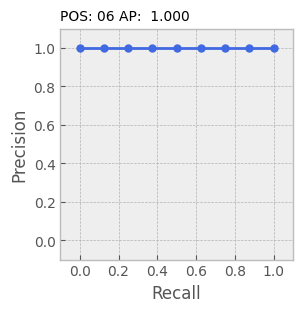

Processing 8 images for label 7


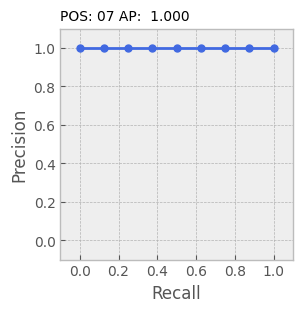

Processing 8 images for label 8


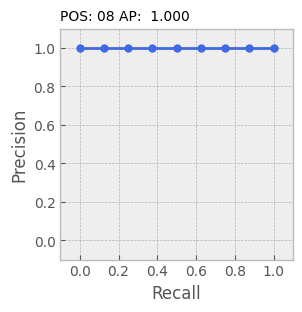

Processing 8 images for label 9


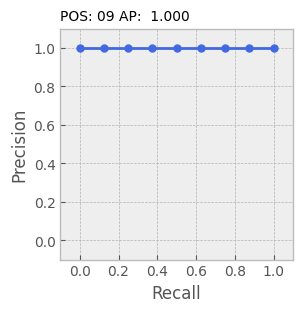

Processing 8 images for label 10


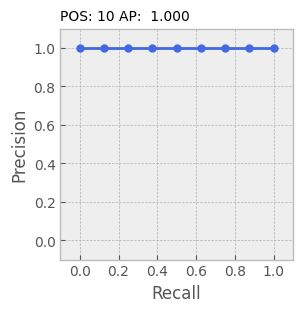

Processing 7 images for label 11


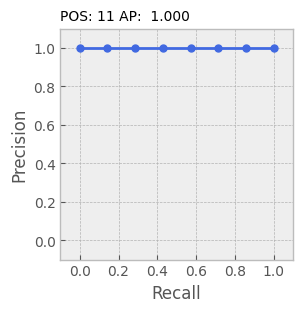

Processing 6 images for label 12


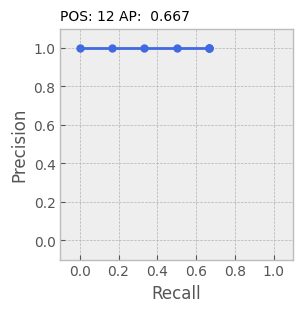

Processing 8 images for label 13


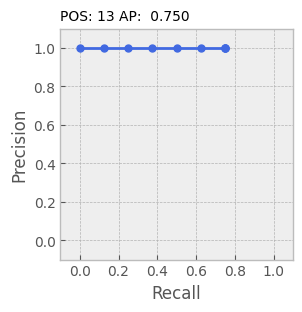

Processing 7 images for label 14


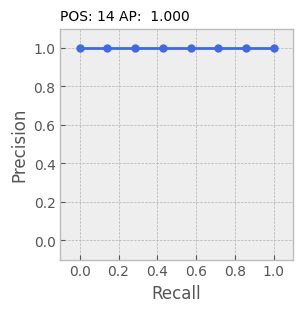

Processing 8 images for label 15


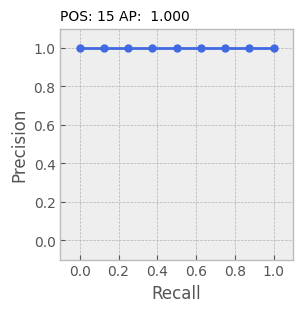

Processing 5 images for label 16


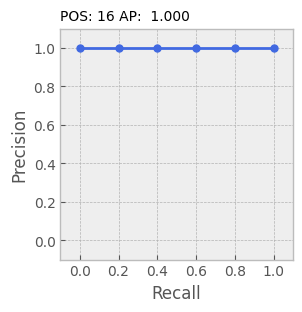

Processing 5 images for label 17


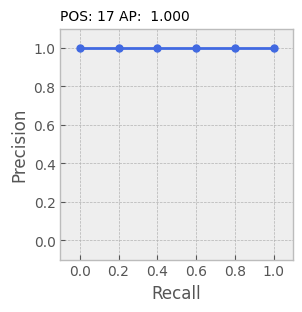

Processing 6 images for label 18


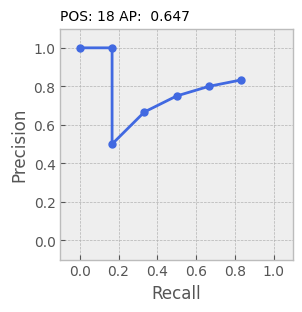

Processing 6 images for label 19


/tmp/ipykernel_156/995737636.py:19: RuntimeWarning: invalid value encountered in divide
  cs_precision = cs_tp / (cs_tp + cs_fp)


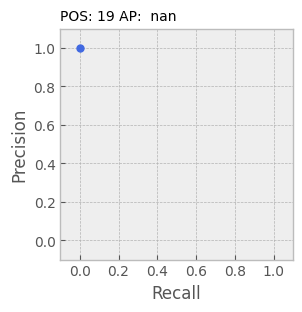

Processing 6 images for label 20


/tmp/ipykernel_156/995737636.py:19: RuntimeWarning: invalid value encountered in divide
  cs_precision = cs_tp / (cs_tp + cs_fp)


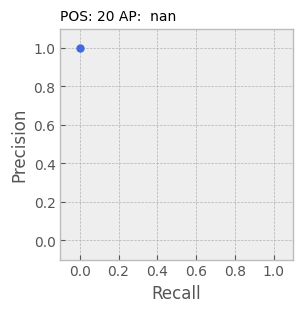

Processing 8 images for label 21


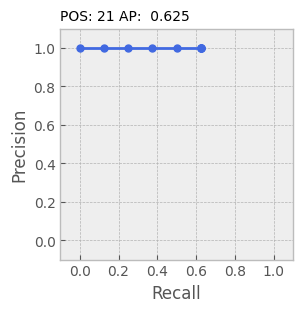

Processing 8 images for label 22


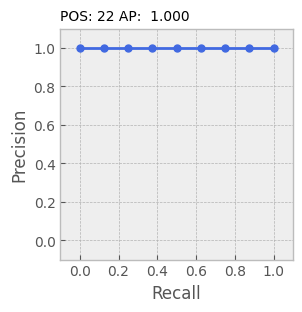

Processing 8 images for label 23


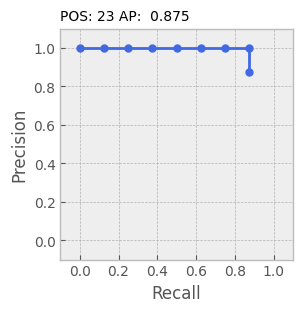

Processing 8 images for label 24


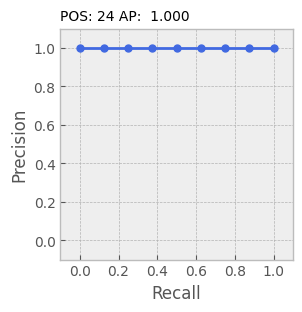

Processing 8 images for label 25


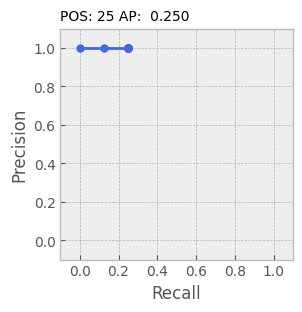

Processing 8 images for label 26


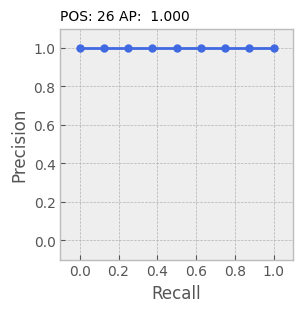

Processing 7 images for label 27


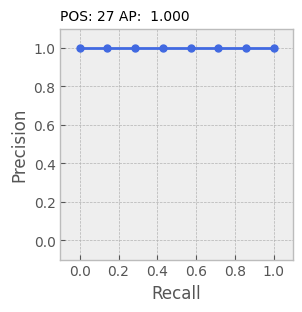

Processing 8 images for label 28


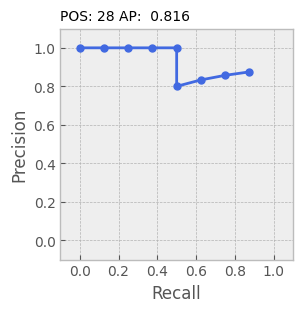

Processing 8 images for label 29


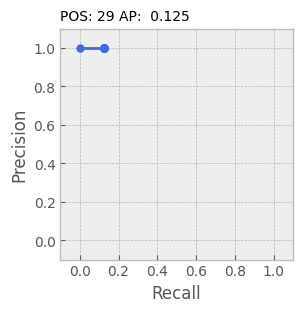

Processing 7 images for label 30


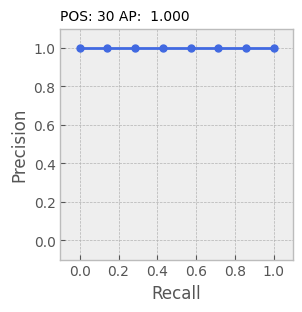

Processing 8 images for label 31


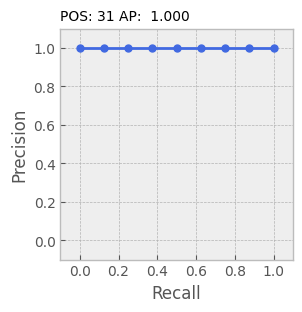

Processing 6 images for label 32


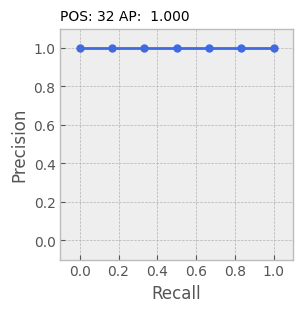

In [288]:
# Loop over all tooth positions
ap_df_list = []
ada_list = sorted(list(df[label_col].unique()))
for l, label in enumerate(ada_list):
    
    df_label = df.loc[(df[dset_col] == dset) & (df[label_col] == label)]
    df_label_files = sorted(list(df_label['file_name'].unique()))
    print(f'Processing {len(df_label_files)} images for label {label}')
    
    output_df_label_list = []
    for f, file_name in enumerate(df_label_files):
        # print(f'Label {label} Image {f + 1} / {len(df_label_files)}')
        
        file_basename = file_name.split('.')[0]
        file = os.path.join(image_dir, file_name)
        im = ImageData().load_image(file)
        im_eq = ImageData().hist_eq(im)
        
        # Ground truth bounding box
        bbox = list(df_label.loc[df_label['file_name'] == file_name, bbox_col].tolist()[0])
        
        # Predictions for this image
        output_df = predict_bboxes(model=model, image=im, threshold=nms_threshold, id2label=id2label)
        output_df = output_df.loc[output_df['label'] == label]
        
        if len(output_df) > 0:
            # We have a prediction for this label in the image
            # Now we need to determine if it is a good one (true positive, TP)
            predicted_bbox = output_df['bbox'].tolist()[0]
            predicted_score = output_df['score'].tolist()[0]
            np_iou = get_iou(bbox_1=bbox, bbox_2=predicted_bbox, bbox_format='xywh', method='np')
            iou = get_iou(bbox_1=bbox, bbox_2=predicted_bbox, bbox_format='xywh', method='pt')
            if iou_threshold <= iou:
                prediction = 'TP'
            else:
                prediction = 'FP'
        else:
            predicted_bbox = None
            predicted_score = None
            iou = np.nan
            prediction = 'FN'
            new_row = pd.DataFrame({'label': label}, index=[0])
            output_df = pd.concat([output_df, new_row], axis=0, ignore_index=True)
        
        # Add some important data to the output
        output_df = output_df.assign(true_bbox=[bbox],
                                     iou=iou, 
                                     file_name=file_name,
                                     nms_threshold=nms_threshold,
                                     iou_threshold=iou_threshold,
                                     prediction=prediction)
        output_df = output_df.rename(columns={'bbox': 'predicted_bbox'})
        
        # Save this prediction
        output_df_label_list.append(output_df)
        
        # Show the result
        if predicted_bbox is not None:
            bbox_list = [bbox, predicted_bbox]
            label_list = [f'T{str(label).zfill(2)}', f'P{str(label).zfill(2)}:{predicted_score:.3f}']
            color_list = ['r', 'b']
        else:
            bbox_list = [bbox]
            label_list = [f'T{str(label).zfill(2)}']
            color_list = ['r']
        
        # Show the images (comment if not needed)
        # fig, ax = plt.subplots(figsize=figsize)
        # ax = show_image_with_boxes(image=im_eq, 
        #                            bbox_list=bbox_list, 
        #                            label_list=label_list, 
        #                            alpha=1.0, 
        #                            colors=color_list, 
        #                            ax=ax)
        # ax.set_title(f'POS: {str(label).zfill(2)} {file_basename} IoU_thr: {iou_threshold} IoU: {np_iou: .3f} {prediction}', 
        #              loc='left', fontsize=10)
        # output_file_name = f'{file_basename}_{prediction}.png'
        # output_file = os.path.join(output_dir, output_file_name)
        # plt.savefig(output_file, bbox_inches='tight')
        # plt.show()
    
    # Create one data frame with all predictions
    output_df_label = pd.concat(output_df_label_list, axis=0, ignore_index=True).\
                    sort_values(by='score', ascending=False).\
                    reset_index(drop=True)
    
    # Calculate ap_metrics
    preds = output_df_label['prediction'].tolist()
    scores = output_df_label['score'].tolist()
    ap_output_label = ap_scores(preds, scores)
    cs_recall = ap_output_label.get('cs_recall')
    cs_precision = ap_output_label.get('cs_precision')
    ap_score = ap_output_label.get('ap_score')
    
    #Plot the result
    plt.style.use('bmh')
    color = 'royalblue'
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.plot(cs_recall, cs_precision, color=color, marker='o', markersize=5)
    ax.plot(cs_recall, cs_precision, color=color, linewidth=0.5)
    ax.set(xlim=[-0.1, 1.1], xticks=np.arange(0, 1.1, 0.2),
           ylim=[-0.1, 1.1], yticks=np.arange(0, 1.1, 0.2))
    ax.set(xlabel='Recall', ylabel='Precision')
    ax_title = f'POS: {str(label).zfill(2)} AP: {ap_score: .3f}'
    ax.set_title(ax_title, loc='left', fontsize=10)
    example_file_name = f'dentex_{str(label).zfill(2)}_PR.png'
    example_file = os.path.join(output_dir, example_file_name)
    # plt.savefig(example_file, bbox_inches='tight')
    plt.show()
    
    ap_dict = {'label_ada': label,
               'nms_threshold': nms_threshold,
               'iou_threshold': iou_threshold,
               'n_images': len(df_label_files),
               'ap_score': ap_score,
               'precision': ap_output_label.get('precision'),
               'recall': ap_output_label.get('recall'),
               'fscore': ap_output_label.get('f_score')}
    
    ap_df_label = pd.DataFrame(ap_dict, index=[0])
    ap_df_list.append(ap_df_label)

### Average precision calculation ###
Follow the example:
https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/

### Create a function to calculate the ap scores ###

In [279]:
score_list = [12, 11, 10, 9, 8, 7, 6, np.nan, np.nan, np.nan, np.nan, np.nan] 
pred_list = ['TP', 'FP', 'TP', 'FP', 'TP', 'TP', 'TP', 'FN', 'FN', 'FN', 'FN', 'FN']

# Make a data frame
pred_df = pd.DataFrame({'score': score_list,
                        'prediction': pred_list})

pred_df = pred_df.sample(frac=1)

scores = pred_df['score'].tolist()
preds = pred_df['prediction'].tolist()

# We use this as an input into the function
print(preds)
print(scores)

['FP', 'TP', 'TP', 'TP', 'FP', 'TP', 'FN', 'FN', 'FN', 'TP', 'FN', 'FN']
[11.0, 10.0, 8.0, 7.0, 9.0, 6.0, nan, nan, nan, 12.0, nan, nan]


In [280]:
output = ap_scores(preds=preds, scores=scores)
cs_recall = output.get('cs_recall')
cs_precision = output.get('cs_precision')

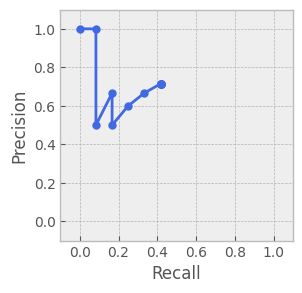

In [281]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(cs_recall, cs_precision, color='royalblue', marker='o', markersize=5)
ax.plot(cs_recall, cs_precision, color='royalblue', linewidth=0.5)
ax.set(xlim=[-0.1, 1.1], xticks=np.arange(0, 1.1, 0.2),
       ylim=[-0.1, 1.1], yticks=np.arange(0, 1.1, 0.2))
ax.set(xlabel='Recall', ylabel='Precision')
example_file_name = 'pr_example.png'
example_file = os.path.join(output_dir, example_file_name)
plt.savefig(example_file, bbox_inches='tight')
plt.show()

['TP', 'TP', 'FN', 'FN', 'TP', 'TP']
[0.22858518362045288, 0.23980554938316345, nan, nan, 0.24921131134033203, 0.22477759420871735]


{'cs_precision': array([1., 1., 1., 1., 1., 1., 1.]),
 'cs_recall': array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667, 0.66666667, 0.66666667]),
 'ap_score': 0.6666666666666666,
 'precision': 0.7142857142857143,
 'recall': 0.8333333333333334,
 'f_score': 0.7692307692307692}

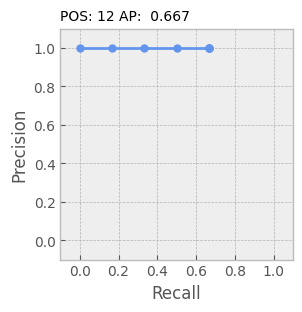

In [242]:
preds = output_df_label['prediction'].tolist()
scores = output_df_label['score'].tolist()
print(preds)
print(scores)
output = ap_scores(preds=preds, scores=scores)
display(output)
cs_recall = output.get('cs_recall')
cs_precision = output.get('cs_precision')

#Plot the result
plt.style.use('bmh')
color = 'cornflowerblue'
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(cs_recall, cs_precision, color=color, marker='o', markersize=5)
ax.plot(cs_recall, cs_precision, color=color, linewidth=0.5)
ax.set(xlim=[-0.1, 1.1], xticks=np.arange(0, 1.1, 0.2),
       ylim=[-0.1, 1.1], yticks=np.arange(0, 1.1, 0.2))
ax.set(xlabel='Recall', ylabel='Precision')
ax_title = f'POS: {str(label).zfill(2)} AP: {output.get('ap_score'): .3f}'
ax.set_title(ax_title, loc='left', fontsize=10)
example_file_name = f'dentex_{str(label).zfill(2)}_PR.png'
example_file = os.path.join(output_dir, example_file_name)
# plt.savefig(example_file, bbox_inches='tight')
plt.show()